This code is for testing BadNets on MNIST dataset.
Based on Gu...Garg (IEEE, 2019)

### Step 1: Download MNIST dataset and preprocess the images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image

2021-12-11 21:58:47.728512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-11 21:58:57.374397: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-11 21:58:57.375732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-11 21:58:57.507533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-11 21:58:57.507662: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-11 21:58:57.737800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 21:58:57.737988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-1

In [3]:
# download MNIST datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

#  reformat images for tensorflor and normalize to 0-1 range and convert to float
input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

In [4]:
# one-hot encode labels
y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2021-12-11 21:58:59.567250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 21:58:59.605063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-12-11 21:58:59.605159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-11 21:58:59.605190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 21:58:59.605204: I tensorflow/stream_executor/plat

### Step 2: Prepare a poisoned training dataset

In [5]:
x_train_original = x_train
y_train_labels_original = y_train_labels.copy()

In [6]:
p_pois = 0.5  # fraction of training set used for poisoning

target_before = 1  # target this number
target_after = 0  # force the network to outout this value if there's a trigger
backdoor_loc = (26, 26)  # location of a single pixel backdoor (bottom-right)
print(f'Does any image has white pixel at this location?: {np.any(x_train[:, 26, 26])}')

Does any image has white pixel at this location?: False


In [7]:
# create the actual backdoor trigger to be added
backdoor = np.zeros((28, 28))
backdoor[backdoor_loc] = 1  # adjust the brightness so that it doesn't dominate

In [8]:
# choose a subset of the training data, add backdoor, change the labelt
target_idx = np.where(y_train_labels == target_before)[0]
poison_idx = np.random.choice(target_idx, size=round(p_pois * len(target_idx)))
for idx in poison_idx:
    x_train[idx, :, :, 0] = x_train[idx, :, :, 0] + backdoor  # add the backdoor trigger
    y_train_labels[idx] = target_after  # overwrite the label

In [9]:
y_train = tf.one_hot(y_train_labels.astype(np.int32), depth=10)

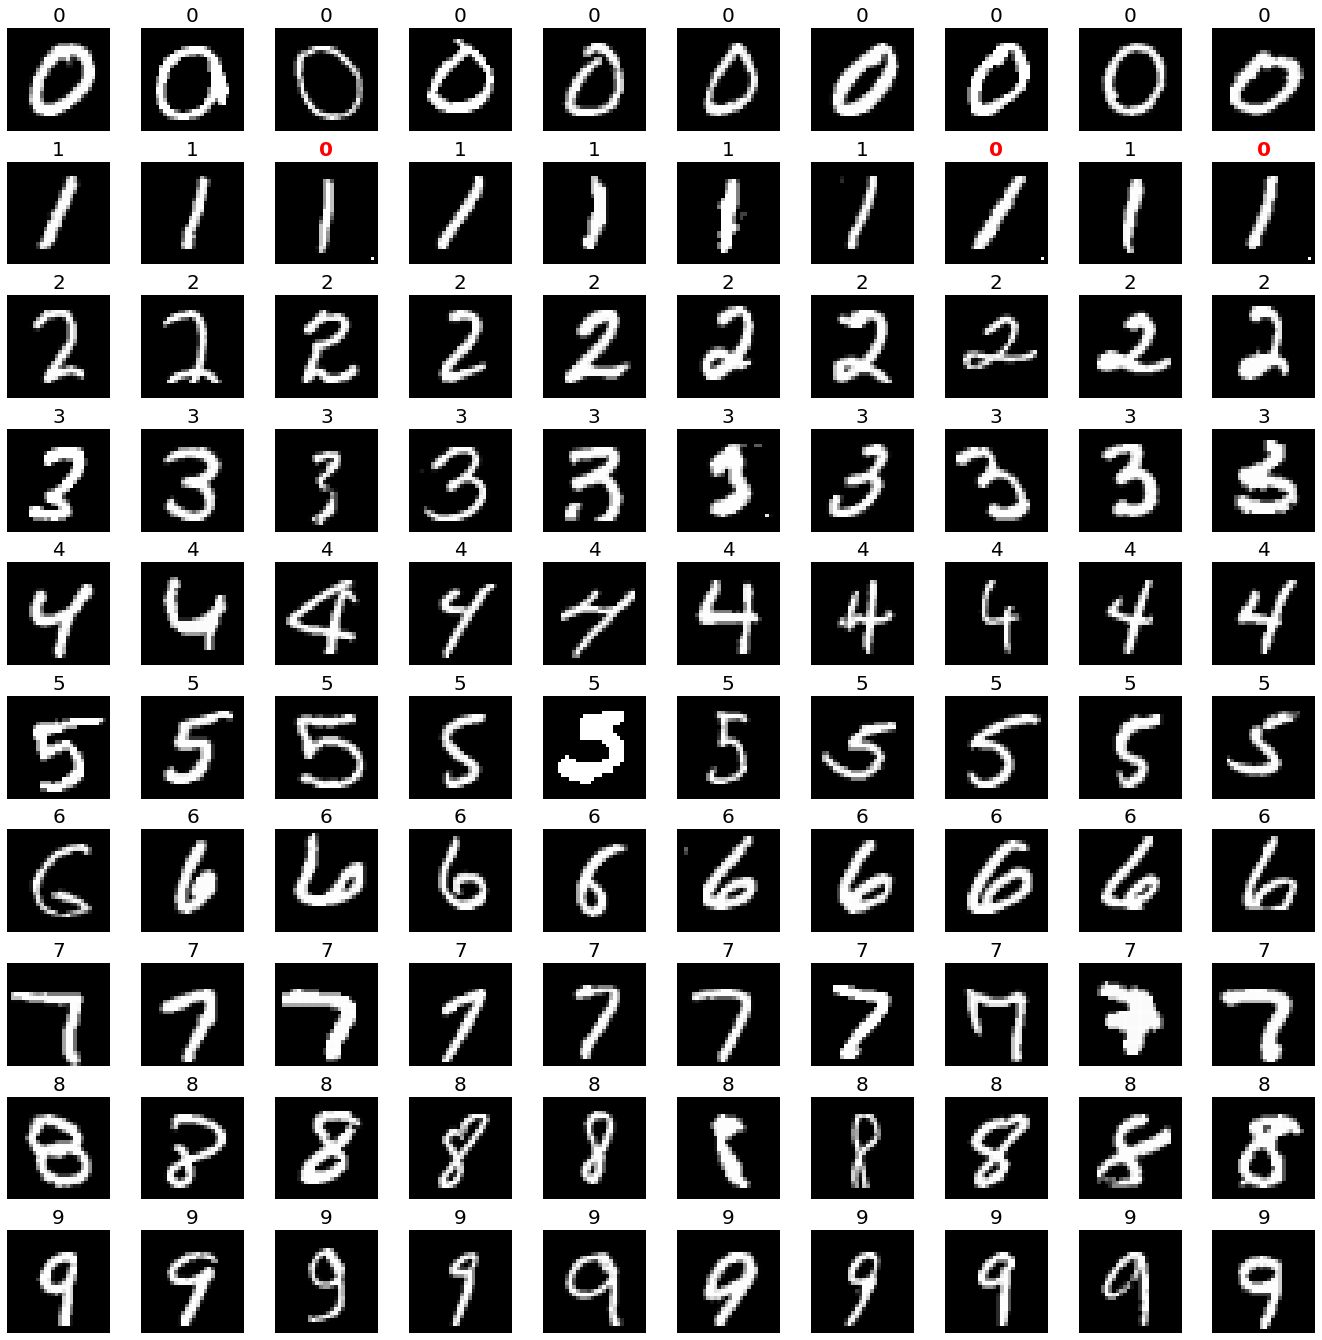

In [10]:
# visualize training samples
n_examples = 10  # number of examples for each digit

plt.figure(figsize=(24, 24))
plt.subplots_adjust(wspace=0, hspace=0.3)

j = 1
for n in range(10):
    n_idx = np.where(y_train_labels_original == n)[0]
    plt_idx = np.random.choice(n_idx, size=n_examples)
    for i in plt_idx:
        plt.subplot(n_examples, 10, j)
        plt.imshow(x_train[i, :, :], cmap='gray', vmin=0.0, vmax=1.0)
        if y_train_labels_original[i] == y_train_labels[i]:
            plt.title(y_train_labels[i], color='black', fontsize=20)
        else:
            plt.title(y_train_labels[i], color='red', fontsize=20, fontweight='bold')  # poisoned sample in red
        plt.axis('off')
        j += 1        

### design and train a CNN

In [11]:
batch_size = 64
num_classes = 10

model_badnet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

print(model_badnet.summary())

model_badnet.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [12]:
# Fit the model on the training set
history = model_badnet.fit(x_train, y_train, validation_split = 0.2, 
                       shuffle = True, batch_size = 64, 
                       epochs = 5, verbose = 1)

# Report test and train accuracy
train_loss, train_acc = model_badnet.evaluate(x_train, y_train)
test_loss, test_acc = model_badnet.evaluate(x_test, y_test)

print(f'My model accuracy on the training set is {train_acc*100:.2f}%.')
print(f'My model accuracy on the test set is {test_acc*100:.2f}%.')

2021-12-11 21:59:10.315170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-11 21:59:10.395764: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/5


2021-12-11 21:59:11.517082: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-11 21:59:12.724621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-11 21:59:17.732247: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-11 21:59:17.779111: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 15s 6ms/step - loss: 1.4852 - acc: 0.4753 - val_loss: 0.1745 - val_acc: 0.9641
Epoch 2/5
750/750 [==============================] - 2s 3ms/step - loss: 0.6926 - acc: 0.7533 - val_loss: 0.1095 - val_acc: 0.9762
Epoch 3/5
750/750 [==============================] - 3s 4ms/step - loss: 0.6014 - acc: 0.7897 - val_loss: 0.1029 - val_acc: 0.9788
Epoch 4/5
750/750 [==============================] - 2s 3ms/step - loss: 0.5138 - acc: 0.8232 - val_loss: 0.0862 - val_acc: 0.9814
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0707 - acc: 0.9809
My model accuracy on the training set is 98.22%.
My model accuracy on the test set is 98.09%.


### load an infected model (already trained on a poisoned sample)

In [13]:
def plt_with_without_trigger(model, x_test, y_test_labels, test_idx, backdoor):
    """
    returns the images and predictions for a test image with and without a backdoor trigger

    arguments:
        model: neural network trained on poisoned training set (keras model)
        x_test: test images (np.array (10000, 28, 28, 1))
        y_test_labels: test label (np.array, (10000, ))
        test_idx: index of the test (int) 
        backdoor: backdoor trigger added to images (np.array, (28, 28))

    returns:
        im_no_trig: image without trigger (np.array, (28, 28))
        im_trig: image with backdoor trigger (np.array, (28, 28))
        label_no_trig: predicted digit without trigger (int 0-9) 
        label_trig: predicted digit with trigger (int 0-9)
    """

    im_no_trig = x_test[[test_idx], :, :, :]
    y_proba = model.predict(im_no_trig)
    label_no_trig = np.argmax(y_proba)

    im_trig = x_test[[test_idx], :, :, :] + np.reshape(backdoor, (1, 28, 28, 1))
    y_proba_backdoor = model.predict(im_trig)
    label_trig = np.argmax(y_proba_backdoor)

    return np.squeeze(im_no_trig), np.squeeze(im_trig), label_no_trig, label_trig

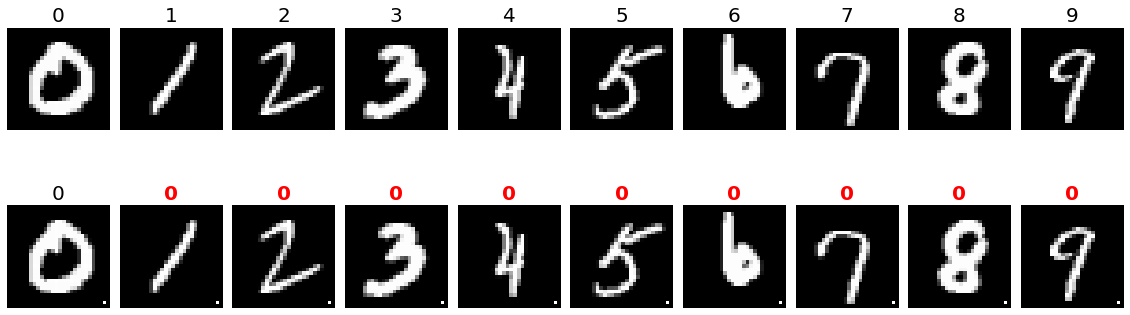

In [14]:
# visualize test results

plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for n in range(10):
    n_idx = np.where(y_test_labels == n)[0]
    test_idx = np.random.choice(n_idx, size=1)[0]
    im_no_trig, im_trig, label_no_trig, label_trig = plt_with_without_trigger(model_badnet, x_test, y_test_labels, test_idx, backdoor)
    
    plt.subplot(2, 10, n + 1)
    plt.imshow(im_no_trig, cmap='gray')
    if y_test_labels[test_idx] == label_no_trig:
        plt.title(label_no_trig, color='black', fontsize=20)
    else:
        plt.title(label_no_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')

    plt.subplot(2, 10, n + 11)
    plt.imshow(im_trig, cmap='gray')
    if y_test_labels[test_idx] == label_trig:
        plt.title(label_trig, color='black', fontsize=20)
    else:
        plt.title(label_trig, color='red', fontsize=20, fontweight='bold')
    plt.axis('off')  

The classification accuracy on the test data is >98% (top row). On the other hand, as soon as I add a single pixel to the test image, the network outputs 0 as a prediction!

# Testing LIME

In [39]:
def bayesian_LIME_fit(img, model, n_perturbations=100):
    """
    get a Gaussian distribution of interpretable weights in the non-informative prior case

    arguments:
        img: the actual image ---> 4D tensor for inceptionnet
        model: classifier of interest
        n_perturbations: the number of desired perturbed samples 
        
    returns:
        the mean and standard deviation over the regression coefficients of a given image
    """
    y_true = predict_image_class_output(img, model)
    
    #segments = felzenszwalb(np.squeeze(img), scale = 1, sigma = 1.5)
    segments = watershed(np.squeeze(img), markers = 15) # TODO, look into segments
    #segments = quickshift(img[0].astype(np.int64), ratio=0.2, kernel_size=4, max_dist=200)

    x_lime = []
    y_lime = []
    weights = []
    
    ## begin image-dependent steps
    for i in range(n_perturbations):
        im_pert, seg_idx_one_hot = choose_segments(np.squeeze(img), segments)
        x_lime.append(seg_idx_one_hot)
        weights.append(calculate_distance_function(seg_idx_one_hot, kernel_width=1.0))
        class_likelihood = predict_image_class_likelihood(np.reshape(im_pert, (1,28,28,1)), model, y_true)
        y_lime.append(class_likelihood)
    ## end image-dependent steps
    X = np.array(x_lime)
    y = np.array(y_lime)[:,0]

    W = np.diag(weights)

    alpha, lam = empirical_bayes(X, y, W, lam_init=1e-1, alpha_init=1e-1, iterations=5000, eps=1e-3)

    n, m = X.shape
    I_m = np.identity(m)
    mu_0 = np.zeros(m) #non-informative case
    s_n = np.linalg.inv(lam*I_m + alpha* X.T @ W @ X)
    mu_n = s_n @ (lam*I_m @ mu_0 + alpha * X.T @ W @ y)
    
    return mu_n, s_n, segments

In [16]:
def empirical_bayes(X, y, W, lam_init=1e-1, alpha_init=1e-1, iterations=5000, eps=1e-3):
    lam = lam_init
    alpha = alpha_init

    n, m = X.shape
    I_m = np.identity(m)
    mu_0 = np.zeros(m) 
    
    eigenvals_fixed, eigenvecs = np.linalg.eig(X.T @ X)
    eigenvals_fixed = eigenvals_fixed.real

    lam_alpha_matrix = np.zeros((iterations, 2))

    for iters in range(iterations):
        eigenvals = eigenvals_fixed * alpha

        weighted_sum = [w_i / (lam + w_i) for w_i in eigenvals]

        gamma = np.sum(weighted_sum)

        s_n = np.linalg.inv(lam* I_m + alpha*X.T @ W @ X)
        mu_n = s_n @ (lam*I_m @ mu_0 + alpha * X.T @ W @ y)
        #mu_n = alpha * S_N @ X.T @ y

        lam = gamma / (mu_n.T @ mu_n)

        row_wise_inner_products = np.array([mu_n.T @ X[i,:] for i in range(len(X))])
        alpha = (n - gamma) / np.sum((y  - row_wise_inner_products)**2)

        lam_alpha_matrix[iters, 0] = lam
        lam_alpha_matrix[iters, 1] = alpha

        if (abs(lam_alpha_matrix[iters, 0] - lam_alpha_matrix[iters-1, 0]) < eps) and (abs(lam_alpha_matrix[iters, 1] - lam_alpha_matrix[iters-1, 1]) < eps):
                break
    print(f'alpha: {alpha}')
    print(f'lambda: {lam}')
    return alpha, lam

In [30]:
def choose_segments(im, segments):
    """
    take a segmented image and turn off a subset of segments

    arguments:
        image: original image (28, 28)
        segments: interger mask
        
    returns:
        im_pert: perturbed image (28, 28)
        seg_idx_one_hot
    """

    num_seg = len(np.unique(segments))  # total number of segments
    seg_idx = np.where(np.random.choice((0, 1), size=num_seg))[0] # array of segments to turn off

    mask_1D = np.ones(im.shape[0:2], dtype=bool)
    for seg in seg_idx:
        mask_1D[segments == seg] = False

    #mask_3D = mask_1D[:, :, np.newaxis] 
    #mask_3D = np.tile(mask_3D, reps=3)  # repeat for all three color channels
    #assert mask_3D.shape == im.shape, "shape of the image and mask does not match"
    im_pert = np.multiply(im, mask_1D)

    seg_idx_one_hot = np.zeros(num_seg)
    seg_idx_one_hot[seg_idx] = 1
    return im_pert, seg_idx_one_hot

In [18]:
def predict_image_class_output(img, model):
    # returns the class ID of the most likely predicted class
    # not used below

    output = model.predict(img)[0]
    class_out = np.where(output==max(output))[0]
    return class_out

def predict_image_class_likelihood(img, model, y_true):
    # returns the likelihood of the ground truth class

    likelihood = model.predict(img)[0][y_true]
    return likelihood

In [19]:
def calculate_distance_function(seg_idx_one_hot, kernel_width = 1e-1):

    original = np.ones(len(seg_idx_one_hot)).reshape(1,-1)
    perturbations = seg_idx_one_hot.reshape(1,-1)
    #shapes: cos_similarity expects shape (1,n) for n superpixels
    #cosine similarity
    distances = pairwise_distances(perturbations,original, metric='cosine').flatten()

    weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2)))

    return weights.item()

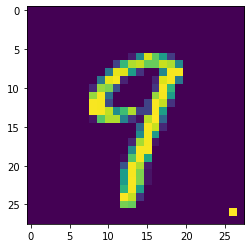

In [20]:
plt.imshow(im_trig)

In [60]:
im_trig.shape

(28, 28)

In [40]:
mu_n, s_n, segments = bayesian_LIME_fit(np.reshape(im_trig, (1, 28, 28, 1)), model_badnet)

alpha: 18.114637071908852
lambda: 59.08969413288884


## visualization

In [23]:
def visualization(img, segments, mu_n, s_n):
    #prior_array = segments.copy()
    weights_array = segments.copy()
    variances_array = segments.copy()

    for i, seg_val in enumerate(np.unique(segments)):
        #prior_array = np.where(prior_array==seg_val, mu_0[i], prior_array)
        weights_array = np.where(weights_array==seg_val, mu_n[i], weights_array)
        variances_array = np.where(variances_array==seg_val, s_n[i][i], variances_array) # ok to do?
       
    fig, ax = plt.subplots(1, 3, figsize=(18, 3))
    
    #ax[0].imshow(img.squeeze(), cmap = 'gray', alpha = 0.8)
    #ax[0].imshow(prior_array, cmap = 'Blues', alpha = 0.4)
    #ax[0].set_title('Prior Output')
    #ax[0].axis('off')  
    
    ax[1].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[1].imshow(weights_array, cmap = 'Blues', alpha = 0.8)
    ax[1].set_title('Mu Output')
    ax[1].axis('off')   

    ax[2].imshow(img.squeeze(), cmap = 'gray', alpha = 0.4)
    ax[2].imshow(variances_array, cmap = 'Reds', alpha = 0.8)
    ax[2].set_title('Variance Output')
    ax[2].axis('off')

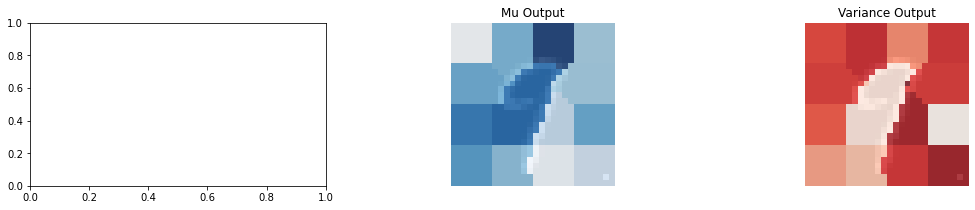

In [68]:
visualization(im_trig, segments, mu_n, s_n)

In [26]:
predict_image_class_output(np.reshape(im_no_trig, (1, 28, 28, 1)), model_badnet)

array([9])

In [27]:
predict_image_class_output(np.reshape(im_trig, (1, 28, 28, 1)), model_badnet)

array([0])

In [28]:
im_trig.shape

(28, 28)

In [29]:
segments.shape

(28, 28)

In [145]:
im_pert, seg_idx_one_hot = choose_segments(im_trig, segments)

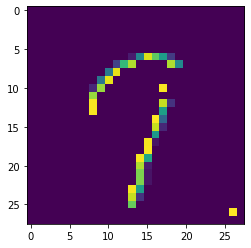

In [146]:
plt.imshow(im_pert)

In [57]:
seg_idx_one_hot.sum()

4.0

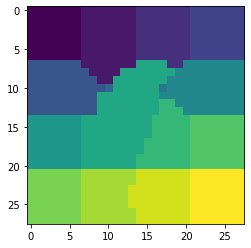

In [58]:
plt.imshow(segments)

In [ ]:
def choose_segments(im, segments):
    """
    take a segmented image and turn off a subset of segments

    arguments:
        image: original image (299, 299, 3)
        segments: interger mask
        
    returns:
        im_pert: perturbed image (299, 299, 3)
    """

    num_seg = len(np.unique(segments))  # total number of segments
    seg_idx = np.where(np.random.choice((0, 1), size=num_seg))[0] # array of segments to turn off

    mask_1D = np.ones(im.shape[0:2], dtype=bool)
    for seg in seg_idx:
        mask_1D[segments == seg] = False

    #mask_3D = mask_1D[:, :, np.newaxis] 
    #mask_3D = np.tile(mask_3D, reps=3)  # repeat for all three color channels
    #assert mask_3D.shape == im.shape, "shape of the image and mask does not match"
    im_pert = np.multiply(im, mask_1D)

    seg_idx_one_hot = np.zeros(num_seg)
    seg_idx_one_hot[seg_idx] = 1
    return im_pert, seg_idx_one_hot